In [12]:
!rm -rf repo
!git clone https://github.com/SNbappy/geometric-shapes-cnn.git repo

import os, random, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# base paths
BASE_DIR = "/content/repo"
TRAIN_DIR = os.path.join(BASE_DIR, "dataset", "train")
TEST_DIR  = os.path.join(BASE_DIR, "dataset", "test")
PHONE_DIR = os.path.join(BASE_DIR, "phone_images")
MODEL_DIR = os.path.join(BASE_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

# quick checks
print("Train folder exists:", os.path.exists(TRAIN_DIR))
print("Test folder exists: ", os.path.exists(TEST_DIR))
print("Phone_images exists: ", os.path.exists(PHONE_DIR))
print("Phone images count:", len([f for f in os.listdir(PHONE_DIR) if f.lower().endswith(('.jpg','.png','.jpeg'))]))


Cloning into 'repo'...
remote: Enumerating objects: 30031, done.
remote: Counting objects: 100% (30031/30031), done.
remote: Compressing objects: 100% (25462/25462), done.
remote: Total 30031 (delta 4571), reused 30029 (delta 4569), pack-reused 0 (from 0)
Receiving objects: 100% (30031/30031), 21.72 MiB | 22.00 MiB/s, done.
Resolving deltas: 100% (4571/4571), done.
Updating files: 100% (30013/30013), done.
Device: cuda
Train folder exists: True
Test folder exists:  True
Phone_images exists:  True
Phone images count: 13


In [13]:
IMG_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [14]:
train_full = ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = ImageFolder(TEST_DIR, transform=test_transform)

val_size = int(0.15 * len(train_full))
train_size = len(train_full) - val_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_full.classes
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Sizes -> Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Classes: ['circle', 'square', 'triangle']
Sizes -> Train: 20400 Val: 3600 Test: 6000


In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        # compute flatten size depends on IMG_SIZE and number of poolings (3 pools -> /8)
        final_size = 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8)
        self.fc1 = nn.Linear(final_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> /2
        x = self.pool(F.relu(self.conv2(x)))  # -> /4
        x = self.pool(F.relu(self.conv3(x)))  # -> /8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN(num_classes=NUM_CLASSES).to(device)
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [16]:
MODEL_PATH = os.path.join(MODEL_DIR, "190110.pth")
TRAIN_MODEL = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10

if (not TRAIN_MODEL) and os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Loaded saved model:", MODEL_PATH)
else:
    print("Training model from scratch...")
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        all_pred = []
        all_true = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_pred.extend(preds)
            all_true.extend(labels.cpu().numpy())
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100.0 * np.mean(np.array(all_pred) == np.array(all_true))
        # validation
        model.eval()
        v_running = 0.0
        v_pred, v_true = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                v_running += criterion(outputs, labels).item() * images.size(0)
                preds = outputs.argmax(dim=1).cpu().numpy()
                v_pred.extend(preds)
                v_true.extend(labels.cpu().numpy())
        val_loss = v_running / len(val_loader.dataset)
        val_acc = 100.0 * np.mean(np.array(v_pred) == np.array(v_true))
        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc)
        print(f"Epoch {epoch}/{EPOCHS} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}% | Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")
    # save weights
    torch.save(model.state_dict(), MODEL_PATH)
    print("Saved model to", MODEL_PATH)


Training model from scratch...
Epoch 1/10 - Train loss: 1.0298, Train acc: 43.55% | Val loss: 0.8501, Val acc: 58.25%
Epoch 2/10 - Train loss: 0.7256, Train acc: 65.38% | Val loss: 0.5435, Val acc: 74.64%
Epoch 3/10 - Train loss: 0.4439, Train acc: 80.09% | Val loss: 0.3472, Val acc: 83.78%
Epoch 4/10 - Train loss: 0.3279, Train acc: 85.25% | Val loss: 0.2758, Val acc: 87.67%
Epoch 5/10 - Train loss: 0.2782, Train acc: 87.37% | Val loss: 0.2366, Val acc: 89.44%
Epoch 6/10 - Train loss: 0.2437, Train acc: 89.05% | Val loss: 0.2217, Val acc: 90.56%
Epoch 7/10 - Train loss: 0.2267, Train acc: 90.12% | Val loss: 0.1989, Val acc: 91.36%
Epoch 8/10 - Train loss: 0.2084, Train acc: 90.78% | Val loss: 0.1888, Val acc: 91.86%
Epoch 9/10 - Train loss: 0.1982, Train acc: 91.34% | Val loss: 0.1911, Val acc: 92.00%
Epoch 10/10 - Train loss: 0.1911, Train acc: 91.63% | Val loss: 0.1766, Val acc: 92.83%
Saved model to /content/repo/model/190110.pth


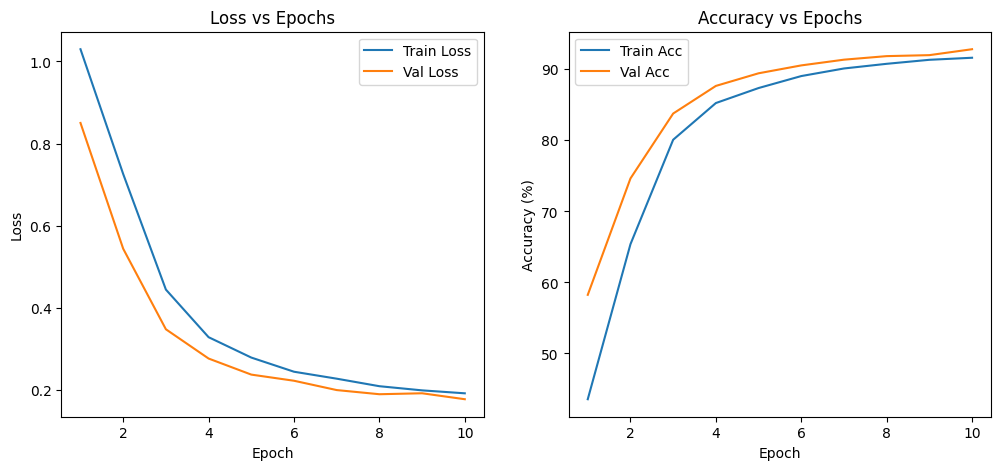

In [17]:
try:
    # variables train_losses etc exist if we trained
    _ = train_losses
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
    plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy vs Epochs')
    plt.show()
except NameError:
    print("Training history not available (model loaded). You can set TRAIN_MODEL=True and retrain to produce plots.")


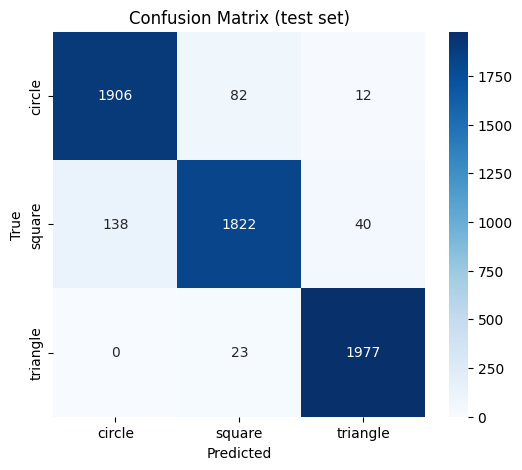

In [18]:
# =============================
# CELL 7 — CONFUSION MATRIX on standard TEST set
# =============================
model.eval()
all_preds = []; all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (test set)")
plt.show()


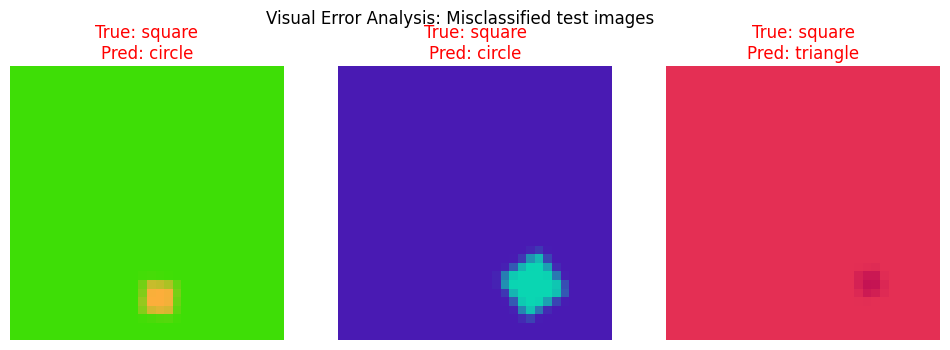

In [19]:
mis = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for img_tensor, true_idx, pred_idx in zip(images.cpu(), labels.cpu(), preds.cpu()):
            if int(true_idx) != int(pred_idx):
                # unnormalize for display: (x*std)+mean (std=0.5, mean=0.5)
                img = img_tensor.permute(1,2,0).numpy()
                img = (img * 0.5) + 0.5
                mis.append((img, class_names[int(true_idx)], class_names[int(pred_idx)]))
# sample 3 random images (if <3 available, show what's available)
k = min(3, len(mis))
if k == 0:
    print("No misclassifications found in test set.")
else:
    idxs = random.sample(range(len(mis)), k)
    plt.figure(figsize=(12,4))
    for i,j in enumerate(idxs):
        img, true, pred = mis[j]
        plt.subplot(1,k,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true}\nPred: {pred}", color='red')
    plt.suptitle("Visual Error Analysis: Misclassified test images")
    plt.show()


Total phone imgs: 13 | correct: 11 | misclassified: 2


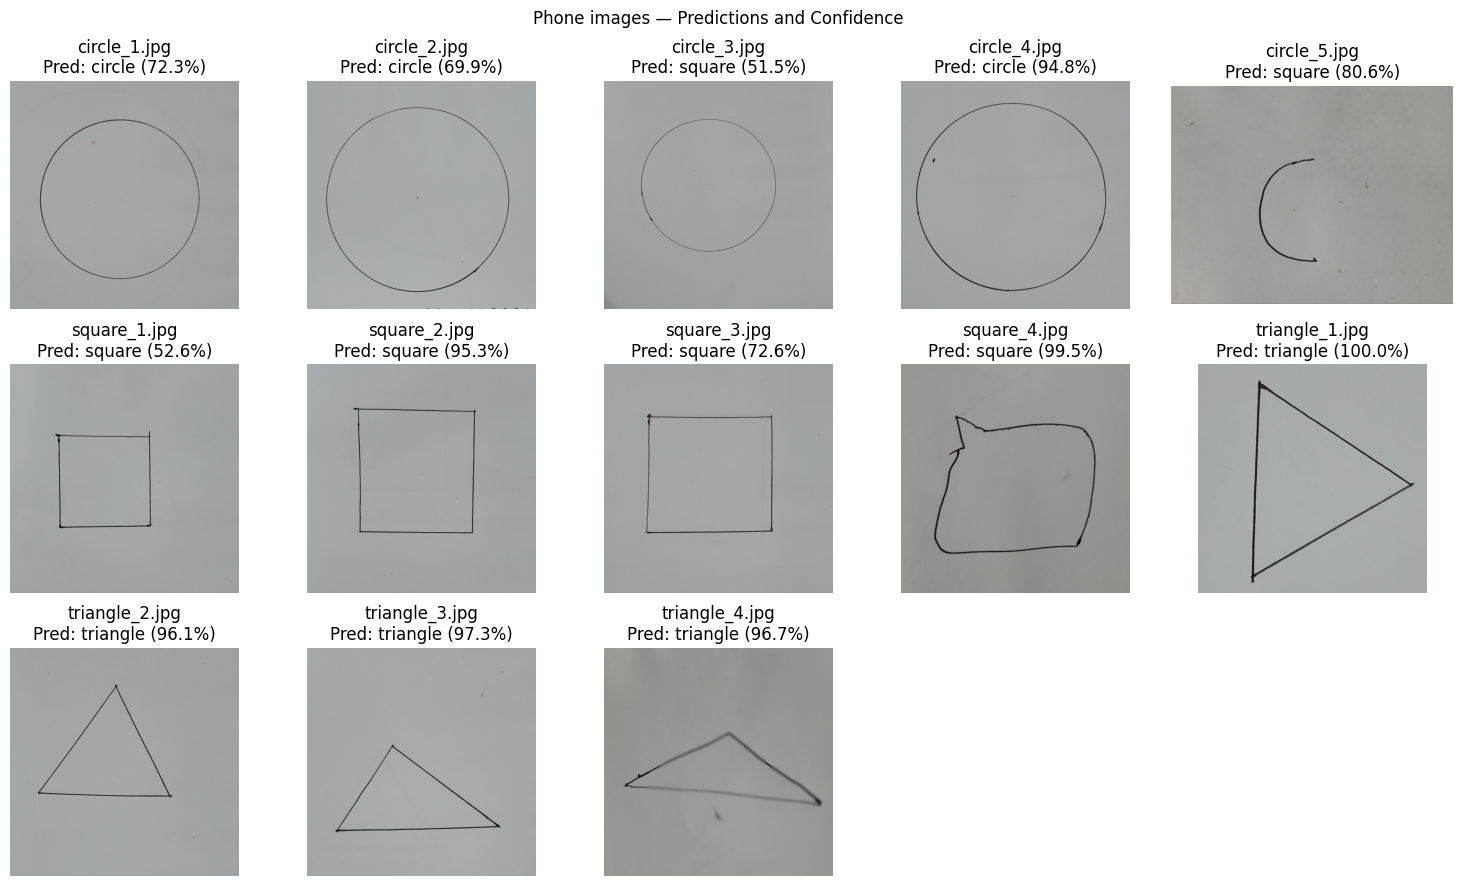

/tmp/ipython-input-3153721549.py:70: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


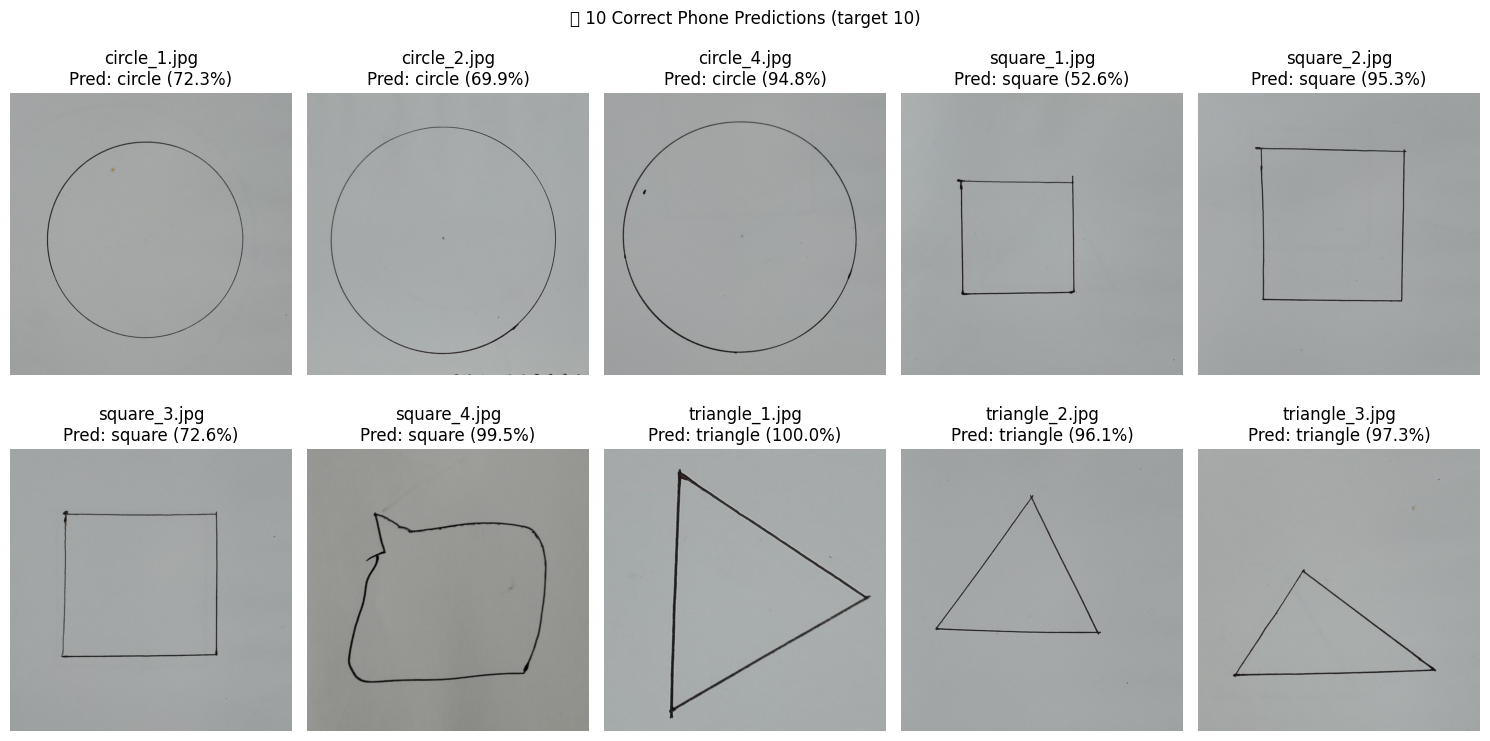

/tmp/ipython-input-3153721549.py:106: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


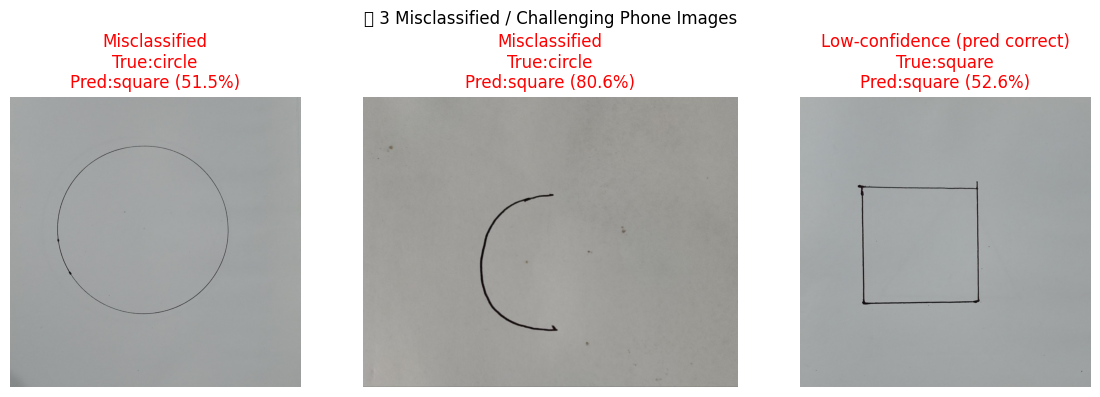

In [20]:
import torch.nn.functional as F

phone_results = []
model.eval()
for fname in sorted(os.listdir(PHONE_DIR)):
    if not fname.lower().endswith(('.jpg','.png','.jpeg')):
        continue
    img_path = os.path.join(PHONE_DIR, fname)
    pil = Image.open(img_path).convert('RGB')
    x = test_transform(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1)[0].cpu().numpy()
        pred_idx = int(probs.argmax())
        conf = float(probs[pred_idx] * 100)
        pred_label = class_names[pred_idx]
    fname_lower = fname.lower()
    if 'circle' in fname_lower:
        true_label = 'circle'
    elif 'triangle' in fname_lower:
        true_label = 'triangle'
    elif 'square' in fname_lower:
        true_label = 'square'
    else:
        true_label = 'unknown'
    phone_results.append({
        'img_pil': pil,
        'fname': fname,
        'true': true_label,
        'pred': pred_label,
        'conf': conf,
        'is_correct': (pred_label == true_label)
    })

print(f"Total phone imgs: {len(phone_results)} | correct: {sum([1 for r in phone_results if r['is_correct']])} | misclassified: {sum([1 for r in phone_results if not r['is_correct']])}")

n = len(phone_results)
cols = 5
rows = math.ceil(n/cols)
plt.figure(figsize=(cols*3, rows*3))
for i, r in enumerate(phone_results):
    plt.subplot(rows, cols, i+1)
    plt.imshow(r['img_pil'])
    plt.axis('off')
    plt.title(f"{r['fname']}\nPred: {r['pred']} ({r['conf']:.1f}%)")
plt.suptitle("Phone images — Predictions and Confidence")
plt.tight_layout()
plt.show()

correct_phone = [r for r in phone_results if r['is_correct']]
num_show_correct = min(10, len(correct_phone))
plt.figure(figsize=(15,8))
for i, r in enumerate(correct_phone[:num_show_correct]):
    plt.subplot(2,5,i+1)
    plt.imshow(r['img_pil'])
    plt.axis('off')
    plt.title(f"{r['fname']}\nPred: {r['pred']} ({r['conf']:.1f}%)")
plt.suptitle(f"✅ {num_show_correct} Correct Phone Predictions (target 10)")
plt.tight_layout()
plt.show()

if num_show_correct < 10:
    print(f"⚠️ Only {num_show_correct} phone images were correctly predicted. To reach 10 correct: retake clearer images or retrain with augmentation.")

incorrect_phone = [r for r in phone_results if not r['is_correct']]

if len(incorrect_phone) >= 3:
    chosen_incorrect = incorrect_phone[:3]
else:
    chosen_incorrect = incorrect_phone[:]
    remaining = 3 - len(chosen_incorrect)
    sorted_by_conf = sorted(phone_results, key=lambda x: x['conf'])
    for cand in sorted_by_conf:
        if cand in chosen_incorrect:
            continue
        chosen_incorrect.append(cand)
        if len(chosen_incorrect) >= 3:
            break

plt.figure(figsize=(12,4))
for i, r in enumerate(chosen_incorrect[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(r['img_pil'])
    plt.axis('off')
    if r['is_correct']:
        title = f"Low-confidence (pred correct)\nTrue:{r['true']}\nPred:{r['pred']} ({r['conf']:.1f}%)"
    else:
        title = f"Misclassified\nTrue:{r['true']}\nPred:{r['pred']} ({r['conf']:.1f}%)"
    plt.title(title, color='red')
plt.suptitle("❌ 3 Misclassified / Challenging Phone Images")
plt.tight_layout()
plt.show()
